In [1]:
import time
import json
import shutil
import os
import feather
import pandas as pd
import numpy as np
import zlib
import json
import random
import requests
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

import logging
logging.basicConfig(level=logging.INFO)

In [2]:
def extract_file(file_path):
    file_suffix = file_path.split('.')[-1]
    unzipped_path = file_path.replace('.' + file_suffix, '')
    
    if not os.path.exists(unzipped_path):
        with gzip.open(file_path, 'rb') as f_in:
            with open(unzipped_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    
    return unzipped_path


def read_every_line(fname, max_lines=-1):
    lines = []
    with open(fname, encoding='utf-8') as f:
        for i, line in enumerate(f):
            lines.append(line.replace('\n',''))
            if i > max_lines and max_lines > 0:
                break 
    return lines


def decompress_stream(stream):
    o = zlib.decompressobj(16 + zlib.MAX_WBITS)

    for chunk in stream:
        yield o.decompress(chunk)

    yield o.flush()

In [68]:
zlib.MAX_WBITS

15

In [3]:
cols_to_keep = ['ts', 'url', 'languages']

def parse_index_file(file_name):
    # Read data from file
    with open(file_name, 'rb') as f:
        data = f.read()
    
    # Decode data
    string_data = data.decode('UTF-8')  
    
    # Parse data
    lines = string_data.split('\n')
    file_data = []
    
    for line in lines:
        if line:
            ts = line.split('{')[0].split()[-1] # timestamp
            line_json = '{' + line.split('{')[-1]
            try:
                line_data = json.loads(line_json)
                line_data.update({'ts': ts})
            except:
                logging.debug('Error parsing json data {} in file {}'.format(line_json, file_name))
                line_data = {}

            file_data.append(line_data)
    
    # Covert from JSON to DataFrame
#     print('...Lines extracted: {}'.format(len(file_data)))
    df = json_normalize(file_data)
    df = df.drop_duplicates().reset_index(drop=True)
    df = df.drop(columns=[col for col in df.columns if col not in cols_to_keep])
    
    return df

In [3]:
# Set variables for Paths File and remote / web location
yearmonth = '2019-47'
url_prefix = 'https://commoncrawl.s3.amazonaws.com/'
paths_file_name = 'cc-index.paths.gz'

# Variables derives from the above
# storage_folder = './crawl-data/CC-MAIN-' + yearmonth
storage_folder = '../data/raw/'
paths_file = os.path.join(storage_folder, paths_file_name)
paths_file_unzipped = extract_file(paths_file)

# Read paths from paths file, convert to URLs
paths = read_every_line(paths_file_unzipped, 1e8)
print('{} lines extracted'.format(len(paths)))
path_urls = [url_prefix + path for path in paths]

302 lines extracted


In [4]:
# Save index files to their own folder
index_folder = os.path.join(storage_folder, 'index-files/')

if not os.path.isdir(index_folder):
    os.mkdir(index_folder)

Previously, downloaded 700 chunks per file. This generated ~900,000 URLs. We want ~3X that.

In [ ]:
dir_size = 0
for f in os.listdir(index_folder):
    dir_size += os.path.getsize(os.path.join(index_folder, f))

In [10]:
print(f'Directory size is {dir_size} MB, or {int(dir_size/1000)} KB, or {int(dir_size/1000000)} GB')

Directory size is 467300467 MB, or 467300 KB, or 467 GB


In [27]:
# Visit each index URL, download & save chunks
n_chunks = 2200 # initial estimate was 669; tried 700. Need 3x as much ==> 2100
start_time = time.time()

for c, url in enumerate(path_urls, 1):
    
    # Derive save-to path from url
    save_file_name = url.split('/')[-1].replace('.gz', '')
    
    if 'cdx-' in save_file_name: # don't download non cdx-index files
        save_path = os.path.join(index_folder, save_file_name)

        # Open a stream Request to the URL, define generator
        r = requests.get(url, stream=True)
        data_stream = decompress_stream(r.iter_content(1024))

        # Create file, wrtie data chunks to it:
        save_file = open(save_path, 'wb')

        if c % 10 == 0 or c == 1:
            sys.stdout.write('\rDownloading file {} out of {}'.format(c, len(path_urls)))
            sys.stdout.flush()

        for i in range(n_chunks):
            chunk = next(data_stream)
            if chunk:
                save_file.write(chunk)

        # Close file & Request connection
        save_file.close()
        r.close()


duration = (time.time() - start_time) / 60
print('Downloads complete!')
print('Elapsed time: {:.0f} minutes'.format(duration))

Elapsed time: 11 minutes


In [28]:
dir_size = 0
for f in os.listdir(index_folder):
    dir_size += os.path.getsize(os.path.join(index_folder, f))

print(f'Directory size is {dir_size} MB, or {int(dir_size/1000)} KB, or {int(dir_size/1000000)} GB')

Directory size is 468484900 MB, or 468484 KB, or 468 GB


In [29]:
# Process / parse the files
i = 1
master_df = pd.DataFrame()

start_time = time.time()
for file in os.listdir(index_folder): #[:50]:
    if 'cdx-' in file:
        if i % 10 == 0 or i == 1:
            sys.stdout.write('\rParsing file {} out of {}'.format(i, len(os.listdir(index_folder))))
            sys.stdout.flush()
        
        file_path = os.path.join(index_folder, file)
        df = parse_index_file(file_path)
        
        master_df = pd.concat([master_df, df], sort=False)
        i += 1

print('')
print('Parsing complete! {:,} total records extracted.'.format(len(master_df)))
print('Elapsed time: {:.0f} minutes'.format(duration))

Parsing file 300 out of 301
Parsing complete! 900,000 total records extracted.
Elapsed time: 11 minutes


This is not quite the 2.8 Million I'd hoped for

In [30]:
print('Saving DataFrame...')
data_path = '../data/raw/'
master_file = 'cc_urls_' + yearmonth
feather.write_dataframe(master_df, os.path.join(data_path, master_file))

Saving DataFrame...


In [37]:
# Visit each index URL, download & save chunks
n_chunks = 1000 # initial estimate was 669; tried 700. Need 3x as much ==> 2100
chunk_size = 1024
start_time = time.time()

for c, url in enumerate(path_urls[:5], 1):
    
    # Derive save-to path from url
    save_file_name = url.split('/')[-1].replace('.gz', '')
    
    if 'cdx-' in save_file_name: # don't download non cdx-index files
        save_path = os.path.join(index_folder, save_file_name)
#         print(f'Old file size: {os.path.getsize(save_path):,}')

        # Open a stream Request to the URL, define generator
        r = requests.get(url, stream=True)
        file_size = int(r.headers['Content-Length'])
        total_chunks = file_size / chunk_size
        print(f'Number of chunks in file {int(total_chunks):,}')
        
        data_stream = decompress_stream(r.iter_content(chunk_size))
        
        # Create file, wrtie data chunks to it:
        save_file = open(save_path, 'wb')

#         if c % 10 == 0 or c == 1:
#             sys.stdout.write('\rDownloading file {} out of {}'.format(c, len(path_urls)))
#             sys.stdout.flush()

        for i in range(n_chunks):
#             print(i)
            if i % 100 == 0 or i == 0:
                sys.stdout.write('\rDownloading chunk {} out of {}'.format(i, n_chunks))
                sys.stdout.flush()
            chunk = next(data_stream)
            if chunk:
                save_file.write(chunk)

        # Close file & Request connection
        save_file.close()
        r.close()
#         print(f'New file size: {os.path.getsize(save_path):,}')
        print('')
        


duration = (time.time() - start_time) / 60
print('Downloads complete!')
print('Elapsed time: {:.0f} minutes'.format(duration))

Number of chunks in file 675,711
Number of chunks in file 795,057
Number of chunks in file 891,064
Number of chunks in file 634,091
Number of chunks in file 692,414
Downloads complete!
Elapsed time: 0 minutes


In [38]:
file_list = ['cdx-0000' + str(x) for x in range(5)]

In [39]:
file_list

['cdx-00000', 'cdx-00001', 'cdx-00002', 'cdx-00003', 'cdx-00004']

In [40]:
# Process / parse the files
i = 1
master_df = pd.DataFrame()

start_time = time.time()
for file in file_list:#os.listdir(index_folder): #[:50]:
    if 'cdx-' in file:
        if i % 10 == 0 or i == 1:
            sys.stdout.write('\rParsing file {} out of {}'.format(i, len(os.listdir(index_folder))))
            sys.stdout.flush()
        
        file_path = os.path.join(index_folder, file)
        df = parse_index_file(file_path)
        
        master_df = pd.concat([master_df, df], sort=False)
        i += 1

print('')
print('Parsing complete! {:,} total records extracted.'.format(len(master_df)))
print('Elapsed time: {:.0f} minutes'.format(duration))

Parsing file 1 out of 301
Parsing complete! 15,000 total records extracted.
Elapsed time: 0 minutes


In [41]:
file_list = ['cdx-0000' + str(x) for x in range(5, 10)]

In [42]:
file_list

['cdx-00005', 'cdx-00006', 'cdx-00007', 'cdx-00008', 'cdx-00009']

In [43]:
# Process / parse the files
i = 1
master_df = pd.DataFrame()

start_time = time.time()
for file in file_list:#os.listdir(index_folder): #[:50]:
    if 'cdx-' in file:
        if i % 10 == 0 or i == 1:
            sys.stdout.write('\rParsing file {} out of {}'.format(i, len(os.listdir(index_folder))))
            sys.stdout.flush()
        
        file_path = os.path.join(index_folder, file)
        df = parse_index_file(file_path)
        
        master_df = pd.concat([master_df, df], sort=False)
        i += 1

print('')
print('Parsing complete! {:,} total records extracted.'.format(len(master_df)))
print('Elapsed time: {:.0f} minutes'.format(duration))

Parsing file 1 out of 301
Parsing complete! 15,000 total records extracted.
Elapsed time: 0 minutes


In [56]:
save_path = os.path.join(index_folder, 'text.txt')

save_file = open(save_path, 'wb')

#         if c % 10 == 0 or c == 1:
#             sys.stdout.write('\rDownloading file {} out of {}'.format(c, len(path_urls)))
#             sys.stdout.flush()

for i in range(10):
    chunk = b'This is a line \n'
    save_file.write(chunk)

# Close file & Request connection
save_file.close()

In [57]:
with open(save_path, 'rb') as f:
    data = f.read()

print(data)

b'This is a line \nThis is a line \nThis is a line \nThis is a line \nThis is a line \nThis is a line \nThis is a line \nThis is a line \nThis is a line \nThis is a line \n'


In [58]:
# Visit each index URL, download & save chunks
n_chunks = 100 # initial estimate was 669; tried 700. Need 3x as much ==> 2100
chunk_size = 1024
start_time = time.time()

for c, url in enumerate(path_urls[:1], 1):
    
    # Derive save-to path from url
    save_file_name = url.split('/')[-1].replace('.gz', '')
    
    if 'cdx-' in save_file_name: # don't download non cdx-index files
        save_path = os.path.join(index_folder, save_file_name)

        # Open a stream Request to the URL, define generator
        r = requests.get(url, stream=True)
        file_size = int(r.headers['Content-Length'])
        total_chunks = file_size / chunk_size
        print(f'Number of chunks in file {int(total_chunks):,}')
        
        data_stream = decompress_stream(r.iter_content(chunk_size))
        
        # Create file, wrtie data chunks to it:
        save_file = open(save_path, 'wb')

#         if c % 10 == 0 or c == 1:
#             sys.stdout.write('\rDownloading file {} out of {}'.format(c, len(path_urls)))
#             sys.stdout.flush()

        for i in range(n_chunks):
#             print(i)
            if i % 10 == 0 or i == 0:
                sys.stdout.write('\rDownloading chunk {} out of {}'.format(i, n_chunks))
                sys.stdout.flush()
            chunk = next(data_stream)
            if chunk:
                save_file.write(chunk)
                print(f'File size: {os.path.getsize(save_path)}')

        # Close file & Request connection
        save_file.close()
        r.close()
#         print(f'New file size: {os.path.getsize(save_path):,}')
        print('')
        


duration = (time.time() - start_time) / 60
print('Downloads complete!')
print('Elapsed time: {:.0f} minutes'.format(duration))

Number of chunks in file 675,711
File size: 8461
File size: 14624
File size: 21192
File size: 27132
File size: 33061
File size: 38574
File size: 45339
File size: 51835
File size: 58175
File size: 72916
File size: 78991
File size: 83538
File size: 91808
File size: 102570
File size: 113864
File size: 124336
File size: 137572
File size: 150840
File size: 169224
File size: 177800
File size: 187487
File size: 197144
File size: 207400
File size: 217149
File size: 223152
File size: 231036
File size: 239864
File size: 252596
File size: 259243
File size: 264586
File size: 270108
File size: 277058
File size: 285030
File size: 291478
File size: 298008
File size: 304171
File size: 323524
File size: 329723
File size: 337966
File size: 346125
File size: 353114
File size: 357751
File size: 362835
File size: 368890
File size: 378276
File size: 398623
File size: 404027
File size: 409983
File size: 415517
File size: 421193
File size: 427183
File size: 432173
File size: 438273
File size: 443905
File size

In [59]:
# Process / parse the files
i = 1
master_df = pd.DataFrame()

start_time = time.time()
for file in ['cdx-00000']:#os.listdir(index_folder): #[:50]:
    if 'cdx-' in file:
        if i % 10 == 0 or i == 1:
            sys.stdout.write('\rParsing file {} out of {}'.format(i, len(os.listdir(index_folder))))
            sys.stdout.flush()
        
        file_path = os.path.join(index_folder, file)
        df = parse_index_file(file_path)
        
        master_df = pd.concat([master_df, df], sort=False)
        i += 1

print('')
print('Parsing complete! {:,} total records extracted.'.format(len(master_df)))
print('Elapsed time: {:.0f} minutes'.format(duration))

Parsing file 1 out of 302
Parsing complete! 1,380 total records extracted.
Elapsed time: 0 minutes


In [63]:
print(f'Records per chunk: {(1380 / 100):.2f}')

Records per chunk: 13.80


In [65]:
print(f'Chunks per file: {3e6 / 3e2 / 13.8:.1f}')

Chunks per file: 724.6


In [66]:
# Visit each index URL, download & save chunks
n_chunks = 1000 # initial estimate was 669; tried 700. Need 3x as much ==> 2100
chunk_size = 1024
start_time = time.time()

for c, url in enumerate(path_urls[:1], 1):
    
    # Derive save-to path from url
    save_file_name = url.split('/')[-1].replace('.gz', '')
    
    if 'cdx-' in save_file_name: # don't download non cdx-index files
        save_path = os.path.join(index_folder, save_file_name)

        # Open a stream Request to the URL, define generator
        r = requests.get(url, stream=True)
        file_size = int(r.headers['Content-Length'])
        total_chunks = file_size / chunk_size
        print(f'Number of chunks in file {int(total_chunks):,}')
        
        data_stream = decompress_stream(r.iter_content(chunk_size))
        
        # Create file, wrtie data chunks to it:
        save_file = open(save_path, 'wb')

#         if c % 10 == 0 or c == 1:
#             sys.stdout.write('\rDownloading file {} out of {}'.format(c, len(path_urls)))
#             sys.stdout.flush()

        for i in range(n_chunks):
#             print(i)
            if i % 10 == 0 or i == 0:
                sys.stdout.write('\rDownloading chunk {} out of {}'.format(i, n_chunks))
                sys.stdout.flush()
            chunk = next(data_stream)
            if chunk:
                save_file.write(chunk)
#                 print(f'File size: {os.path.getsize(save_path)}')

        # Close file & Request connection
        save_file.close()
        r.close()
#         print(f'New file size: {os.path.getsize(save_path):,}')
        print('')
        


duration = (time.time() - start_time) / 60
print('Downloads complete!')

# Process / parse the files
i = 1
master_df = pd.DataFrame()

start_time = time.time()
for file in ['cdx-00000']:#os.listdir(index_folder): #[:50]:
    if 'cdx-' in file:
        if i % 10 == 0 or i == 1:
            sys.stdout.write('\rParsing file {} out of {}'.format(i, len(os.listdir(index_folder))))
            sys.stdout.flush()
        
        file_path = os.path.join(index_folder, file)
        df = parse_index_file(file_path)
        
        master_df = pd.concat([master_df, df], sort=False)
        i += 1

print('')
print('Parsing complete! {:,} total records extracted.'.format(len(master_df)))
# print('Elapsed time: {:.0f} minutes'.format(duration))

Number of chunks in file 675,711
Downloads complete!
Parsing file 1 out of 302
Parsing complete! 3,000 total records extracted.


In [67]:
# Visit each index URL, download & save chunks
n_chunks = 5000 # initial estimate was 669; tried 700. Need 3x as much ==> 2100
chunk_size = 1024
start_time = time.time()

for c, url in enumerate(path_urls[:1], 1):
    
    # Derive save-to path from url
    save_file_name = url.split('/')[-1].replace('.gz', '')
    
    if 'cdx-' in save_file_name: # don't download non cdx-index files
        save_path = os.path.join(index_folder, save_file_name)

        # Open a stream Request to the URL, define generator
        r = requests.get(url, stream=True)
        file_size = int(r.headers['Content-Length'])
        total_chunks = file_size / chunk_size
        print(f'Number of chunks in file {int(total_chunks):,}')
        
        data_stream = decompress_stream(r.iter_content(chunk_size))
        
        # Create file, wrtie data chunks to it:
        save_file = open(save_path, 'wb')

#         if c % 10 == 0 or c == 1:
#             sys.stdout.write('\rDownloading file {} out of {}'.format(c, len(path_urls)))
#             sys.stdout.flush()

        for i in range(n_chunks):
#             print(i)
            if i % 10 == 0 or i == 0:
                sys.stdout.write('\rDownloading chunk {} out of {}'.format(i, n_chunks))
                sys.stdout.flush()
            chunk = next(data_stream)
            if chunk:
                save_file.write(chunk)
#                 print(f'File size: {os.path.getsize(save_path)}')

        # Close file & Request connection
        save_file.close()
        r.close()
#         print(f'New file size: {os.path.getsize(save_path):,}')
        print('')
        


duration = (time.time() - start_time) / 60
print('Downloads complete!')

# Process / parse the files
i = 1
master_df = pd.DataFrame()

start_time = time.time()
for file in ['cdx-00000']:#os.listdir(index_folder): #[:50]:
    if 'cdx-' in file:
        if i % 10 == 0 or i == 1:
            sys.stdout.write('\rParsing file {} out of {}'.format(i, len(os.listdir(index_folder))))
            sys.stdout.flush()
        
        file_path = os.path.join(index_folder, file)
        df = parse_index_file(file_path)
        
        master_df = pd.concat([master_df, df], sort=False)
        i += 1

print('')
print('Parsing complete! {:,} total records extracted.'.format(len(master_df)))
# print('Elapsed time: {:.0f} minutes'.format(duration))

Number of chunks in file 675,711
Downloads complete!
Parsing file 1 out of 302
Parsing complete! 3,000 total records extracted.


WTH:
- 100 chunks --> 1,300 records
- 1000 chunks --> 3,000 records
- 5000 chunks --> 3,000 records

In [69]:
url = path_urls[0]
r = requests.get(url, stream=True)
file_size = int(r.headers['Content-Length'])
total_chunks = file_size / chunk_size
print(f'Number of chunks in file {int(total_chunks):,}')
data_stream = decompress_stream(r.iter_content(chunk_size))

Number of chunks in file 675,711


In [70]:
data = []
chunk = next(data_stream)
data.append(chunk)

In [71]:
chunk

b'0,0,1)/ 20191118114721 {"url": "http://1.0.0/", "mime": "text/html", "mime-detected": "text/html", "status": "403", "digest": "BSLJKUCKYURNLM3IWKP45ZYNTS3AISL6", "length": "1902", "offset": "14531", "filename": "crawl-data/CC-MAIN-2019-47/segments/1573496669755.17/crawldiagnostics/CC-MAIN-20191118104047-20191118132047-00107.warc.gz"}\n0,0,1)/robots.txt 20191118114721 {"url": "http://1.0.0/robots.txt", "mime": "text/html", "mime-detected": "text/html", "status": "403", "digest": "XJRHYYWVMGQXDNSPYDODVZ7AEWGUZE26", "length": "1908", "offset": "3747", "filename": "crawl-data/CC-MAIN-2019-47/segments/1573496669755.17/robotstxt/CC-MAIN-20191118104047-20191118132047-00070.warc.gz"}\n0,102,126,13:8081)/ 20191121011733 {"url": "http://13.126.102.0:8081/", "mime": "text/html", "mime-detected": "application/xhtml+xml", "status": "200", "digest": "WHIH3EQGQHFPB4LQIEUK6OTOPESI5AFZ", "length": "3914", "offset": "939069", "filename": "crawl-data/CC-MAIN-2019-47/segments/1573496670643.58/warc/CC-MA

In [75]:
data = ''
data += chunk.decode()

In [76]:
len(data)

3883

In [77]:
chunk = next(data_stream)
data += chunk.decode()

In [78]:
len(data)

8461

In [79]:
for _ in range(10):
    chunk = next(data_stream)
    data += chunk.decode()
    print(len(data))

14624
21192
27132
33061
38574
45339
51835
58175
64031
72916


In [80]:
r.close()

In [82]:
import numpy as np

In [85]:
url = path_urls[0]
r = requests.get(url, stream=True)
data_stream = decompress_stream(r.iter_content(chunk_size))

ns = np.arange(1000)
data_size = []

for _ in ns:
    chunk = next(data_stream)
    data += chunk.decode()
    data_size.append(len(data))

r.close()

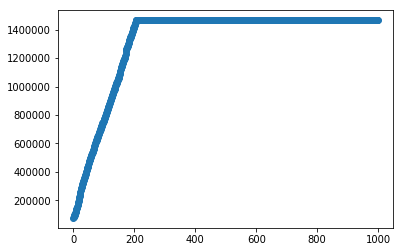

In [88]:
plt.scatter(ns, data_size)

In [100]:
url = path_urls[0]
r = requests.get(url, stream=True)
data_stream = decompress_stream(r.iter_content(chunk_size*8))

ns = np.arange(200)
data_size2 = []

for _ in ns:
    chunk = next(data_stream)
    data += chunk.decode()
    data_size2.append(len(data))

r.close()

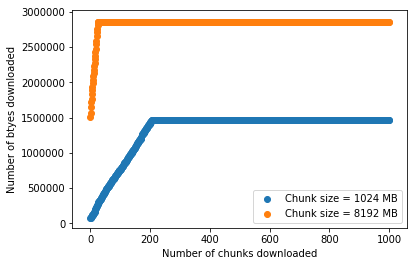

In [94]:
plt.scatter(ns, data_size, label=f'Chunk size = {chunk_size} MB')
plt.scatter(ns, data_size2, label=f'Chunk size = {chunk_size*8} MB')
plt.xlabel('Number of chunks downloaded')
plt.ylabel('Number of btyes downloaded')
plt.legend();

In [95]:
np.argmax(data_size2)

25

Increasing chunk size by 8 doubled the data size.

I needed to triple the data size...

In [99]:
url = path_urls[0]
r = requests.get(url, stream=True)
data_stream = decompress_stream(r.iter_content(chunk_size*16))

ns = np.arange(100)
data_size3 = []

for _ in ns:
    chunk = next(data_stream)
    data += chunk.decode()
    data_size3.append(len(data))

r.close()

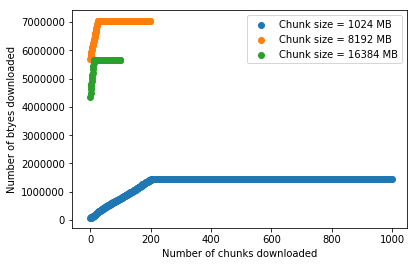

In [102]:
plt.scatter(np.arange(len(data_size)), data_size, label=f'Chunk size = {chunk_size} MB')
plt.scatter(np.arange(len(data_size2)), data_size2, label=f'Chunk size = {chunk_size*8} MB')
plt.scatter(np.arange(len(data_size3)), data_size3, label=f'Chunk size = {chunk_size*16} MB')

plt.xlabel('Number of chunks downloaded')
plt.ylabel('Number of btyes downloaded')
plt.legend();

In [ ]:
url = path_urls[0]

In [107]:
def get_url_data(url, n_chunks, chunk_size):
    r = requests.get(url, stream=True)
    data_stream = decompress_stream(r.iter_content(chunk_size))

    ns = np.arange(n_chunks)
    data = ''
    data_size = []

    for _ in ns:
        chunk = next(data_stream)
        data += chunk.decode()
        data_size.append(len(data))

    r.close()
    
    return ns, data_size

In [105]:
chunk_size

1024

In [109]:
ns8, data_size8 = get_url_data(url, 200, chunk_size*8)

In [110]:
ns16, data_size16 = get_url_data(url, 75, chunk_size*16)

In [111]:
ns4, data_size4 = get_url_data(url, 200, chunk_size*4)

In [112]:
ns = np.arange(1000)

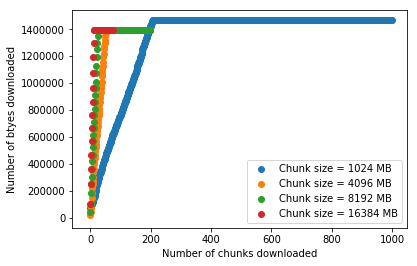

In [113]:
plt.scatter(ns, data_size, label=f'Chunk size = {chunk_size} MB')
plt.scatter(ns4, data_size4, label=f'Chunk size = {chunk_size*4} MB')
plt.scatter(ns8, data_size8, label=f'Chunk size = {chunk_size*8} MB')
plt.scatter(ns16, data_size16, label=f'Chunk size = {chunk_size*16} MB')

plt.xlabel('Number of chunks downloaded')
plt.ylabel('Number of btyes downloaded')
plt.legend();

In [114]:
ns1, data_size1 = get_url_data(url, 500, 512)

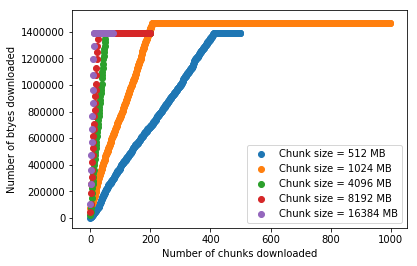

In [115]:
plt.scatter(ns1, data_size1, label=f'Chunk size = 512 MB')
plt.scatter(ns, data_size, label=f'Chunk size = {chunk_size} MB')
plt.scatter(ns4, data_size4, label=f'Chunk size = {chunk_size*4} MB')
plt.scatter(ns8, data_size8, label=f'Chunk size = {chunk_size*8} MB')
plt.scatter(ns16, data_size16, label=f'Chunk size = {chunk_size*16} MB')

plt.xlabel('Number of chunks downloaded')
plt.ylabel('Number of btyes downloaded')
plt.legend();

In [118]:
r = requests.get(url, stream=True)
r.headers['Content-Length']

'691928612'

We are not at the size of the file

In [119]:
r.iter_content(chunk_size = chunk_size)

<generator object Response.iter_content.<locals>.generate at 0x114fe0af0>

In [120]:
r.close()

In [133]:
def decompress_stream_batch(chunk):
    o = zlib.decompressobj(16 + zlib.MAX_WBITS)

    o.decompress(chunk)

    return o.flush()

In [122]:
def get_url_data(url, n_chunks, chunk_size):
    r = requests.get(url, stream=True)
#     data_stream = decompress_stream(r.iter_content(chunk_size))
    data_stream = decompress_stream_batch(r.iter_content(chunk_size))
    
    ns = np.arange(n_chunks)
    data = ''
    data_size = []

    for _ in ns:
        chunk = next(data_stream)
        data += chunk.decode()
        data_size.append(len(data))

    r.close()
    
    return ns, data_size

In [123]:
ns0, data_size0 = get_url_data(url, 500, 1024)

TypeError: 'bytes' object is not an iterator

In [148]:
r.close()

In [149]:
r = requests.get(url, stream=True)
#     data_stream = decompress_stream(r.iter_content(chunk_size))
data_stream = r.iter_content(chunk_size)

In [150]:
data_stream

<generator object Response.iter_content.<locals>.generate at 0x115a6cd58>

In [151]:
chunk = next(data_stream)

In [152]:
chunk

b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x00\x03\xec\xbdis\xe3F\xd2.\xfa\xfd\xfe\x8a\x89\x89\xe8\tw\\\x89B\xed\x80#\x1co`#\t\xee\x0bH\x00\xfc\xd2AI\xec\x16mI\x94)\xc9\xdd\xed\x1b\xe7\xfc\xf6[\x05n@\x01\xa0H\x80\x9b\xe7\x9c\x1e\xdb#\xaa\t\x10\xcc\'\xb3r\xcfT\xae\x94+\xf0\xf9\xe6_P\x01\x1a\x00@\x05\x003\x08\xfe\xf5\xff\xfd\xfb}\xfe\xf8\xef_\xff\xf5\xef\x87\xb7\xb7\x97_on@I))7\xff\xbe\xfa\xd7\xbf\x9f\xa6O\x13\xf1\x17o\x93\x1fo7\x0foO\x8f\xab_^\xdfO\xde&wo\x93\xfb\xc4\xdf\xbe\xbe\x8d\xdf\xde_\xc5\xaf\xb1\x82\xc4/\xee\xa7\xdf&\xafo\xe2\x17F\xbfQ\xab\x0f\xccz0\xe8\xb5\x1aM\xe4x\xf5\x0e&\xa3\xa0\xe5\xf6\x91\xee\xf4\x1bT\xbc\xfbq\xf2\xfc\xed\xedA\xbc\x1bh\n\x14\xbf\x99}\xfd\xfa:\t\xaf\x07\x98  ~\xf5u\xca\xdf6^<\xda\xdd|\xfc\xfd\xf1\xfa~\xfc6\xbe1\xcd\xeb\xa6\xee\xb4\xae\xc5\xd7\xbb\xc6\xec\xe6u\xf2\xedi\xf2\xfc\xf6z\x03\x08CX\xa3\x94j\x8c\x90\x12`7\xe1E\xf7\xd3\xf1\xb7\xe7\xd9\xeb\xdb\xf4\xee5viH\x19\x05+\x98m^"(^*\nPX\xe9\xfbx~W\xfa\xf6\xf7\xbf\xff\xd7\xff\xa3,\xe89\x9f\xdd\xce\xde^Ko?\xdev\xa3\xec

In [134]:
# decomp_chunk = decompress_stream_batch(chunk)

In [135]:
# decomp_chunk

b''

In [153]:
o = zlib.decompressobj(16 + zlib.MAX_WBITS)

In [154]:
o.decompress(chunk)

b'0,0,1)/ 20191118114721 {"url": "http://1.0.0/", "mime": "text/html", "mime-detected": "text/html", "status": "403", "digest": "BSLJKUCKYURNLM3IWKP45ZYNTS3AISL6", "length": "1902", "offset": "14531", "filename": "crawl-data/CC-MAIN-2019-47/segments/1573496669755.17/crawldiagnostics/CC-MAIN-20191118104047-20191118132047-00107.warc.gz"}\n0,0,1)/robots.txt 20191118114721 {"url": "http://1.0.0/robots.txt", "mime": "text/html", "mime-detected": "text/html", "status": "403", "digest": "XJRHYYWVMGQXDNSPYDODVZ7AEWGUZE26", "length": "1908", "offset": "3747", "filename": "crawl-data/CC-MAIN-2019-47/segments/1573496669755.17/robotstxt/CC-MAIN-20191118104047-20191118132047-00070.warc.gz"}\n0,102,126,13:8081)/ 20191121011733 {"url": "http://13.126.102.0:8081/", "mime": "text/html", "mime-detected": "application/xhtml+xml", "status": "200", "digest": "WHIH3EQGQHFPB4LQIEUK6OTOPESI5AFZ", "length": "3914", "offset": "939069", "filename": "crawl-data/CC-MAIN-2019-47/segments/1573496670643.58/warc/CC-MA

In [139]:
# o.flush()

b''

In [155]:
chunk = next(data_stream)

In [156]:
chunk

b'\x19\x803\x8d\xb2\xd7\'\xfe<\xd7O\xe3?&\xb3\xbf&\xf3\xb8\x82!d;\xb5\xa5k\x8fm\n\xe8\xac\xe22F\x11\xea\xf9\xa6\xdb\xf2\x9d \x80\xa8\xdf\xb4GN\xdf\xf2Z:\x92\xd5\x0b\x92\x11\x00\xaaB`1o<\x9f@\x10\x90\xd7Hc\xdc\x81\xa1WH\xfb|#nz\xa3h7\x10\xde<L\x1e\x1fg\xd7\xdfg\xf3\xc7\xfb\xb5\x0f\xc3\x8dO\x92rx!\x8d\xfb/\xdc\x87\x01\x8c\xc3\x95~\x8b\xe2A\x93\x04R\x8d\xb6]n\xf9\x95\xba\xc5\x9a~\xcd\x82Hw\xadF\x9b\xf9\x15\xc4\xb8fiUl\t)\x85\xab\x17\xc9\x81!T\xc5\x04\x17CJ\x85\xa0DH\xba\x9b\t8\x8c\x8a\xb6yI\x90x\xc9\r\x01\xb2\x1fR\x7f?\xcc\xae\xd2\xd0J\xf12C\x84\x94\xed\x08m9\xbe^\x1e\xc7\xd3\xe7lT\xd6\x7f\xbdM\xa3\xf4a\xdb\xa0\xdc\xa3\xb4\xabm\x86\xbd\x96\xd1\x1a6Z6\x1d\x19\x06\x19\xf6\x02\xd7\x91\x0e0(\xe9\x13\x081)\xa8\xef\x97\x90d\xbb\x95Y\xb8p\xe2I\'\x18\xa75EW\x98\xfcJ(M\x8dg\x01\xfe\xbc0\xe5\x04\xe3\xe6\x03\xbfrA\xf0\xf0\xe2\x0c\xaa\xbf?\xff\xb1\x17\xb9\x13\xfa\x029\x18VQ\x9f\xb6Z\xe5.l\xf6\x87>\xf3G\xf5@\x0f\xfa\xa6O\xbaFP\x8b\x93\x1b3(\xcb\x00Q\x0b\x05Z(\xc6\x9c\xb9\xb6D\xb58\x81\xb1\n\xc0\xea%\x

In [157]:
o.decompress(chunk)

b'9195450-20191119223450-00314.warc.gz"}\n0,110,222,18)/smile-makeovers 20191119195855 {"url": "http://18.222.110.0/smile-makeovers/", "mime": "text/html", "mime-detected": "application/xhtml+xml", "status": "200", "digest": "XA7GT77633RXCTNXIYY23SMEZISDWNA3", "length": "29301", "offset": "1805231", "filename": "crawl-data/CC-MAIN-2019-47/segments/1573496670255.18/warc/CC-MAIN-20191119195450-20191119223450-00514.warc.gz", "charset": "UTF-8", "languages": "eng"}\n0,117,106,39)/2019/09/22/hello-world 20191121143531 {"url": "http://39.106.117.0/2019/09/22/hello-world/", "mime": "text/html", "mime-detected": "text/html", "status": "200", "digest": "LOEFNXGKD7MXJD23ATDLO7XG372WTNGE", "length": "20320", "offset": "2568454", "filename": "crawl-data/CC-MAIN-2019-47/segments/1573496670821.55/warc/CC-MAIN-20191121125509-20191121153509-00454.warc.gz", "charset": "UTF-8", "languages": "zho,eng"}\n0,117,106,39)/robots.txt 20191121143530 {"url": "http://39.106.117.0/robots.txt", "mime": "text/plain"

In [158]:
chunk = next(data_stream)

In [159]:
o.decompress(chunk)

b'", "mime": "text/html", "mime-detected": "text/html", "status": "403", "digest": "XCX6MMOKF5FBGHWXDJVK5MQTKXDNWDYV", "length": "656", "offset": "40211", "filename": "crawl-data/CC-MAIN-2019-47/segments/1573496669183.52/crawldiagnostics/CC-MAIN-20191117142350-20191117170350-00226.warc.gz"}\n0,128,2,198)/robots.txt 20191117160700 {"url": "http://198.2.128.0/robots.txt", "mime": "text/html", "mime-detected": "text/html", "status": "403", "digest": "XCX6MMOKF5FBGHWXDJVK5MQTKXDNWDYV", "length": "604", "offset": "12188", "filename": "crawl-data/CC-MAIN-2019-47/segments/1573496669183.52/robotstxt/CC-MAIN-20191117142350-20191117170350-00188.warc.gz"}\n0,128,2,198)/robots.txt 20191120064652 {"url": "http://198.2.128.0/robots.txt", "mime": "text/html", "mime-detected": "text/html", "status": "403", "digest": "XCX6MMOKF5FBGHWXDJVK5MQTKXDNWDYV", "length": "605", "offset": "4500", "filename": "crawl-data/CC-MAIN-2019-47/segments/1573496670512.94/robotstxt/CC-MAIN-20191120060344-20191120084344-001

In [133]:
# def decompress_stream_batch(chunk):
#     o = zlib.decompressobj(16 + zlib.MAX_WBITS)
#     return o.decompress(chunk)

In [20]:
def get_url_data(url, n_chunks, chunk_size):
    r = requests.get(url, stream=True)
#     data_stream = decompress_stream(r.iter_content(chunk_size))
    data_stream = r.iter_content(chunk_size)
    o = zlib.decompressobj(16 + zlib.MAX_WBITS)
    
    ns = np.arange(n_chunks)
    data = ''
    data_size = []

    for _ in ns:
        chunk = next(data_stream)
        decomp_chunk = o.decompress(chunk)
        data += decomp_chunk.decode()
        data_size.append(len(data))

    r.close()
    
    return ns, data_size

In [21]:
ns0, data_size0 = get_url_data(url, 500, 1024)

In [22]:
ns8, data_size8 = get_url_data(url, 125, 1024*8)

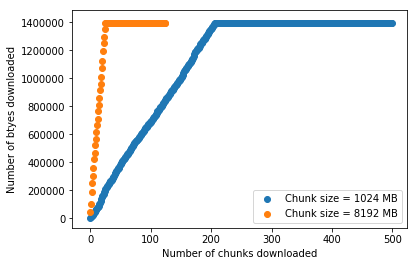

In [26]:
# plt.scatter(ns1, data_size1, label=f'Chunk size = 512 MB')
plt.scatter(ns0, data_size0, label=f'Chunk size = 1024 MB')
# plt.scatter(ns4, data_size4, label=f'Chunk size = {chunk_size*4} MB')
plt.scatter(ns8, data_size8, label=f'Chunk size = {1024*8} MB')
# plt.scatter(ns16, data_size16, label=f'Chunk size = {chunk_size*16} MB')

plt.xlabel('Number of chunks downloaded')
plt.ylabel('Number of btyes downloaded')
plt.legend();

In [27]:
np.argmax(data_size8)

25

In [30]:
np.max(data_size8) / 1e6

1.393277

In [165]:
chunk_size = 1024*8
n_chunks = 23

r = requests.get(url, stream=True)
#     data_stream = decompress_stream(r.iter_content(chunk_size))
data_stream = r.iter_content(chunk_size)
o = zlib.decompressobj(16 + zlib.MAX_WBITS)

ns = np.arange(n_chunks)
data = ''
data_size = []

for _ in ns:
    chunk = next(data_stream)
    decomp_chunk = o.decompress(chunk)
    data += decomp_chunk.decode()
    data_size.append(len(data))


In [166]:
chunk

b'\x15\x8d\xbd\x15Z\xf9\x89\xb9\xb9j\xbaZ\xb5`\xab\xfe/\xb0\xef\x7f\x82\xfd\xe9\xc0\x9a\xb1\x9f\xdbC\x9ayU\xe9\x1buU\'\x1a2k\xa3\x0e\xe2@\xabJ+\x82\xc2\xc9B\n\x16\xa2\x94\\-B=;p\xaa\x8a\x0c\x07Tn=Y\x8a\xac\x00Y&\x8f\x8f@\x96\xf8#;Xd\xc7\xe8\xca&\xba\xcdSu\x87_\xdb\xd5\xb3\x89\xdf\x07=U\x8c\xab\x05t\x98\x01\xdaO\xea=`\xd3y\xac\xba\x01\x82\xa2#\x86\x11\x1e1\xc2\x13y\xa3\xe6\x80+\xd1-\xca\x14\xf7\xe2\xf0\xee\xcc\x87\xba\xe9\xc30u-v\x8f\x00d\xe6l\x9f(\x82\x0ep\xa91N-\x9b&\x011\x05\xb5\xb6\x91t\xc9T*I\xee[\x85\xbbK\xc5Y\xe7\x0c\x84\x7f\x8e\x7f\xb2\xcbc\xf1sy\xac\xdc\xd5w?\xe5\xfeo\xd3\'\xf7\xca#\x10-\xe5\x07\xaf\x82\xe4\x03%l\x89\xe5\xecP\xed=\x9db\xd7\xaa3f\t\n<\x0f\x8e0=\x02\xdc\x92`\xe7\x7fyr3?\xfd>\xbby\xcc\x9b\x00\x00B\xa95mK\x1a`: \x80\x93z\xf3\xc5\x03\x1c\x854\x8b\xc3\xd1P3FZ>\x1a\x8fMW\xc7\xe9\xc8\x8d3\xcd\x0e*3\xb5\x031\x95\x11aY\x941\xcc\xee\xeeY\x01\x8b\x15I\x1d\xd0\xf6\xb3\xc0h\xc4\t\xfbxoK2\xe2\x8f\xec,\xc8\xdb\xe5\x98\xaf\xf9\x7f\rJ\x8b\x1b~\x05I[\xe6\xd6\x06${\xe4\xfe\x86\xd3

In [169]:
len(decomp_chunk), len(data), data_size[-1]

(52457, 1249297, 1249297)

In [170]:
chunk = next(data_stream)
decomp_chunk = o.decompress(chunk)
data += decomp_chunk.decode()
data_size.append(len(data))

In [171]:
len(decomp_chunk), len(data), data_size[-1]

(47320, 1296617, 1296617)

In [172]:
chunk = next(data_stream)
decomp_chunk = o.decompress(chunk)
data += decomp_chunk.decode()
data_size.append(len(data))

In [173]:
len(decomp_chunk), len(data), data_size[-1]

(51954, 1348571, 1348571)

In [174]:
chunk

b')\x89\xfa\x9c\t\xab\xae+\x80\xcd\xa6FEN\xeb(|\xa0\xd7\xde\xf0N\xc1\xa0\x1f\x14S\xf4>\x9aw\xe7~\xd0\xd7\x82z\xc3\xee\xf9\xc8L\xfc\r,G\xc6^\xbe\x84\xe5\xe3:\xc7\x850\x8c}\x97\xa0$\xd7\xfd$r\x9d0\xae\r\nm\xd7K,/\xcd\x08S\xbe\xc2\xb6T\xc4\x8c\x1c\x05D&\x87\xa1\x01\xde\r@\xb2s\x16|\x0b\x80#\x9c\t\x8b0\xc2\x8b\x88\x1d3KA\xa2\x16\x9a\x95\xe6v5\xcc"+\xf4|\xcd,c\xa3u\x91\xef\xb9\tv\xdcMX(\x18\xb4\xd8+\x87q&w\xa7f\x06kE\xa3KasNl\x89\x9c\x10^\x08w\xc6_\xeb\x87\xce\x81\xeb\xab\xf3\x0b\xfe\xae\xfe\xf1\xf9\xfc\xa3\xac\xa8\xbc\xe0\x15\x03\xe9\x97\xaf\xd7\x8b7\xff\xeb5\x13\xfejR\t\x92\xf0H\xb5\x1c\xe1\x0c{dI\x9c-\xad\xaf\xee\\\xa7|\x15\xe7\xba\xba\xbd\xfce\xcb\xa3\x0e\x1f./+\xa3KM#&lO\x19Z\x9eTm\x19\xd4a\xe5z4\x08mW\x1c\x85\x89\xa0\xd8\x1f\x0f\x15D%y\x1a}*f\x9f\x9c\xe2\xf1p9\x90\x01"2^]b\xc0/\xf9v\xdaf\x89Z\x95\xf1\xc1O\x07\xfb\xe9?7W\xcf\xc3\xfb\x04#\x93\xe3\xec\xe2\xf2\x97\xdb\x9b?\x1e>\xfb|~\xf7Q\x96(|\xa0\x02XG\x18\xc1aY\xc9+\x106\x1f\x1e\x90\xa7\x7f<|fl<\xe0\xf0 \x93>4\n-\xa2\tJS\x10v\x9a\xd3\x

In [175]:
chunk = next(data_stream)
decomp_chunk = o.decompress(chunk)
data += decomp_chunk.decode()
data_size.append(len(data))

In [176]:
len(decomp_chunk), len(data), data_size[-1]

(44706, 1393277, 1393277)

In [177]:
chunk = next(data_stream)
decomp_chunk = o.decompress(chunk)
data += decomp_chunk.decode()
data_size.append(len(data))

len(decomp_chunk), len(data), data_size[-1]

(0, 1393277, 1393277)

In [178]:
chunk

b'\x83\xbf\x84\xab\x13a\\\xaa&\x9e\xe00\xc0\x1aMRlj\x95\x03\x01\x8a\x01N\x1db\x94\x01\x89\xfc\xc8\xec\xf1F.\xc6Y\x11\xb0\xa2\xab3\xa4\x1dHX\x1a\xc6\xce\xa5>\x0br\xd8\xe3\'\x01\xb9\xe4\xfd~\xdc\xd0T\xd1m\xad,\x03\x85\x98\x81\xde$Nic\xaa\xa1\x1a\xa2\xc6\xe8I<\x08\xef\x91\x14O$e\x8c\xcb;\xc0\xe2\x1b\xeb\xfd\xe5\x8e\x9d\xff\xfb\x81\x0e\xc0\xd3N\xc8g\x8b\x0b\xc0\xd8@\x0f\xe5\x86\xde\x94\xa9\xe5!9K\x95\\n\x940\xcdP\x19\x07\x81\xe2\xd2\x0fc\x1d\taA\x9cH\xd3\x18U\x17?\xfdfx\x18\x8cw\xcf\xd7Ll\xd1\x7f\xado.\xb77\xdf\xf9z\x8e0\xae6\xdeow\x89{\xe2\xc2\xd3L\x0b\xc3\xd8)Q\\`\xd3\xd5*\x99\xf9gNb\xa2\xdb\x95\xce\x935\xd8y\xc1\x9d\x95\x18!J\xce\xe0\x99P\x9a\x8d\xabq\xb8\xf4\x0f\x9b\xdd\xb7\xf5\xb6\xb7:\x07E\x0c\xc6\xe4 \x1d\x93Kl\xb1ZX\xf9\xb9mR7\xafPc\xd2\xaa&ve\x1b:!F\xac\xdbaOy\x95\xf3MBZ.\xc5\x19\xb6X2/\x90\xef\x915\x04\x08O\xc0\xef3x\x1aZ\xec6\x8d\xef\xab\xa6\x8f\x9c\x84\x1d\x91\x01\x8bn\xb4\xd2QUb\x85Hw:\xb0\x11\xcc\x17r0\x10(\xa4\x93p\x1bG\xd4\x10\xe0\xac\xb8\xbd\\A\xbcW\x1d\x87\x08 4\x1c\xbf\x

In [179]:
o.decompress(chunk)

b''

In [180]:
o.flush()

b''

In [183]:
o.unused_data

b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x00\x03\xdc\xbdYs\x1bI\xb25\xf8>\xbf\xe2Z\xbf]\x9b\xa2\x94\x19k\xe2{\xcb}\xdf\xf7|\xf9\x0c"Q\x12J\x14I\x03\xc9\xae\xae;6\xf3\xdb\'\x92\x8b\x08D&\xc8D.\xc4\xd8tY\xab\n\x92\xe0I\xc4\x81G\xb8{\x1c?.\n\xc2\x1f"\xc6\x7f\xac\xf0\x1f"\x82\xff\xfd\xf5a\xfd\xfd\xeb\xb7\xf5\xcd\xd5zwq\xb5\xb9\xbb\xbd\xdf>\\\xfc\xf5x\xb5\xbd\xd8\xfe\\\xdf\xfc\x17\x10\xc4\x95(\x02 b$B\xf2_\xff\xd7\xbf\x1ew\xd7\xff\xfa_\xff\xf5\xaf\x1f\x0f\x0fw\xff\xeb\xebWf\xe0\xcb\n\x7fa\xe6\xbe\x88\x82\xf0\xae\xa9\xaf\xff\xfa\xe3\xbf\xfe\xf5k\xfbk\xd3\xbe\xfda\xf3\x9f\x87\xaf?\x1e~]\xbf\xfe&\xfb\xfb\x0f\x9b\xcb\x87\xcdU\xe7O\xef\x1f\xd6\x0f\x8f\xf7\xedo\x03Ah\x7f\xe3j\xfb}s\xff\xd0\xfe\x06\xad0R3]\xb5d#\xd4\xe5Tu-\xc5\x8eK\xdf*UT\xc4a\x92\xb6\x7f\xfbzs\xf3\xfd\xe1G\xfb\xb7E\x91`\xdc\xfe\xd6\xed\x9f\x7f\xdeo\x9e\x0c`L\x10\x12\xdb\xdf\xfbs\xcb\xfe\xe2\xfa\xf9\x87\xbb\xdc\xad\xff\xbe\xbe\xb8Z?\xac\xbf\xaa\xea\x85/\xdb\xc1E\xbb\x0c\x17\x88~\xbd\xdf|\xff\xb5\xb9y\xb8\xff*b\n\xd1\x8a\x10\xcaV\x05~\xa

In [186]:
r.close()

In [199]:
chunk_size = 1024*8
n_chunks = 50

r = requests.get(url, stream=True)
#     data_stream = decompress_stream(r.iter_content(chunk_size))
data_stream = r.iter_content(chunk_size)
o = zlib.decompressobj(16 + zlib.MAX_WBITS)

ns = np.arange(n_chunks)
# data = ''
data_size = []
save_file_name = url.split('/')[-1]#.replace('.gz', '')
save_path = os.path.join(index_folder, save_file_name)
save_file = open(save_path, 'wb')

for _ in ns:
    chunk = next(data_stream)
#     decomp_chunk = o.decompress(chunk)
#     data += chunk
#     data_size.append(len(data))
    save_file.write(chunk)
    data_size.append(os.path.getsize(save_path))

r.close()
save_file.close()

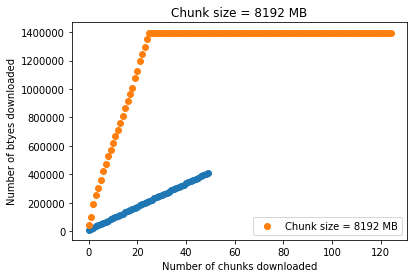

In [200]:
# plt.scatter(ns1, data_size1, label=f'Chunk size = 512 MB')
# plt.scatter(ns0, data_size0, label=f'Chunk size = {chunk_size} MB')
plt.scatter(ns, data_size, label='')

# plt.scatter(ns4, data_size4, label=f'Chunk size = {chunk_size*4} MB')
plt.scatter(ns8, data_size8, label=f'Chunk size = {chunk_size} MB')
# plt.scatter(ns16, data_size16, label=f'Chunk size = {chunk_size*16} MB')

plt.title(f'Chunk size = {chunk_size} MB')
plt.xlabel('Number of chunks downloaded')
plt.ylabel('Number of btyes downloaded')
plt.legend();

In [202]:
import gzip

In [201]:
save_path

'../data/raw/index-files/cdx-00000.gz'

In [203]:
decomp_file = extract_file(save_path)

In [204]:
decomp_file

'../data/raw/index-files/cdx-00000'

In [206]:
with open(decomp_file, 'rb') as f:
    data = f.read()

In [207]:
len(data)

221184

Ran script to download data

In [208]:
for file in os.listdir(index_folder):
    old_path = os.path.join(index_folder, file)
    new_file_name = file + '.gz'
    new_path = os.path.join(index_folder, new_file_name)
    os.rename(old_path, new_path)

Parse Data

In [211]:
file_name = 'cdx-00000.gz'
file_path = os.path.join(index_folder, file)
extracted_path = extract_file(file_path)

EOFError: Compressed file ended before the end-of-stream marker was reached

In [215]:
with gzip.open(file_path, 'rb') as f:
    data = f.readlines()

EOFError: Compressed file ended before the end-of-stream marker was reached

In [216]:
o = zlib.decompressobj(16 + zlib.MAX_WBITS)
CHUNKSIZE = 1024

with gzip.open(file_path, 'rb') as f:
    chunk = f.read(CHUNKSIZE)
    while chunk:
        data = o.decompress(chunk)
        chunk = f.read(CHUNKSIZE)

data += o.flush()

 

error: Error -3 while decompressing data: incorrect header check

In [222]:
o = zlib.decompressobj(16 + 15)
CHUNKSIZE = 1024

with gzip.open(file_path, 'rb') as f:
    chunk = f.read(CHUNKSIZE)
    while chunk:
        data = o.decompress(chunk)
        chunk = f.read(CHUNKSIZE)

data += o.flush()

 

error: Error -3 while decompressing data: incorrect header check

In [225]:
o = zlib.decompressobj(32 + 8)
CHUNKSIZE = 1024

with gzip.open(file_path, 'rb') as f:
    chunk = f.read(CHUNKSIZE)
    while chunk:
        data = o.decompress(chunk)
        chunk = f.read(CHUNKSIZE)

data += o.flush()

error: Error -3 while decompressing data: incorrect header check

In [220]:
o = zlib.decompressobj(-8 + zlib.MAX_WBITS)
CHUNKSIZE = 1024

with gzip.open(file_path, 'rb') as f:
    chunk = f.read(CHUNKSIZE)
    while chunk:
        data = o.decompress(chunk)
        chunk = f.read(CHUNKSIZE)

data += o.flush()

 

ValueError: Invalid initialization option

In [227]:
CHUNKSIZE = 1024

with gzip.open(file_path, 'rb') as f:
    data = f.read()
    decomp_data = gzip.decompress(data)

 

EOFError: Compressed file ended before the end-of-stream marker was reached

It would appear we must decompress while downloading the stream of data

In [228]:
# # Create file, wrtie compressed data chunks to it:
# save_file_name = url.split('/')[-1].replace('.gz', '')
# save_path = os.path.join(index_folder, save_file_name)
# save_file = open(save_path, 'wb')

n_chunks = 25
chunk_size = 1024 * 8

data = ''
data_size = []

# Open a stream Request to the URL, define generator
with requests.get(url, stream=True) as r:
    data_stream = r.iter_content(chunk_size)

    for _ in range(n_chunks):
        chunk = next(data_stream)
        if chunk:
            data = gzip.decompress(chunk)
#             save_file.write(chunk)
            data_size.append(len(data))

# Close file & Request connection
# save_file.close()

EOFError: Compressed file ended before the end-of-stream marker was reached

# 10:16 am 12/15/2019

Try urllib: https://stackoverflow.com/questions/1517616/stream-large-binary-files-with-urllib2-to-file

In [5]:
from urllib.request import urlopen 

In [7]:
url = path_urls[0]

In [8]:
# r = urlopen(url)
# CHUNKSIZE = 8 * 1024

# save_file_name = url.split('/')[-1].replace('.gz', '')
# save_path = os.path.join(index_folder, save_file_name)
# save_file = open(save_path, 'wb')

# with open(save_file, 'wb') as f:
#     while True:
#         chunk = r.read(CHUNKSIZE)
#         if not chunk:
#             break
#         f.write(chunk)

# r.close()

In [9]:
# import requests
import shutil

In [ ]:
def download_file(url):
    local_filename = url.split('/')[-1]
    with requests.get(url, stream=True) as r:
        with open(local_filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)

    return local_filename

In [19]:
r = urlopen(url)
CHUNK_SIZE = 8 * 1024
N_CHUNKS = 27

save_file_name = url.split('/')[-1].replace('.gz', '')
save_path = os.path.join(index_folder, save_file_name)
save_file = open(save_path, 'wb')

r = requests.get(url, stream=True)
data_size = []
ns = np.arange(N_CHUNKS)
data_stream = r.iter_content(CHUNK_SIZE)

# with open(save_file, 'wb') as f:
for i in range(N_CHUNKS):
    print(f'Doing stuff to chunk {i}...')
    chunk = next(data_stream)
    
    with open(os.path.join(index_folder, 'temp.gz'), 'wb') as temp_file:
        temp_file.write(chunk)
        
    shutil.copyfileobj(temp_file, save_file)
    data_size.append(os.path.getsize(save_path))

r.close()
save_file.close()

Doing stuff to chunk 0...


UnsupportedOperation: read

In [14]:
r.close()
save_file.close()

In [ ]:
plt.scatter(ns, data_size)